In [1]:
# To make sure that we use the same packages on different computers
! pip install -r requirements.txt

In [2]:
%load_ext google.cloud.bigquery

# "Will it snow tomorrow?" - The time traveler asked
**The following dataset contains climate information form over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 11 years ago. So if today is 2021.02.15 then the weather we want to forecast is for the date 2010.02.16. You are suppsed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to used BigQuery in Jupyter Notebook refer to the Google Docs.**

**The goal of this test is, to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck at the first part, you can use the replacement data provided in the second part**

My proposed solution to this problem will be as follows in broad terms:

> Step 1: Retrieve and preprocess the data

> Step 2: Train a classifier that can predict whether it will snow or not by looking at relevant features

> Step 3: Train a Recurrent Neural Network (RNN) model to forecast the necessary inputs for the classifier

> Step 4: Predict the snow fall for the target day combining the RNN model and the classifier




*P.S.: This notebook demonstrates the pipeline for solving this problem. Other experimentations and alternative solutions are not included for a better reading experience*

## Part 1

Let's start with the necessary imports

In [3]:
import numpy as np
import pandas as pd
import pickle
import datetime
from datetime import timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from keras.layers import Dense, Input, LSTM
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Task
**Change the date format to 'YYYY-MM-DD' and select the data from 2006 till 2010 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010.**

**Comments: testing simple logical conditining, knowledge about sql syntax, and ability to find in doc how to store as df variable**

First, we need to authenticate the user to access Google Cloud SDK, so that we can use the BigQuery API within Google Colab Notebooks

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
# ID of the project I created on my Google Cloud Console
PROJECT_ID = "l-coding-challenge-309111" 

In [6]:
%%bigquery --project $PROJECT_ID df_task_1
SELECT Date(year, month, day) AS date, * EXCEPT (year, month, day)
FROM `bigquery-public-data.samples.gsod`
WHERE year >= 2006
AND station_number BETWEEN 725300 AND 726300
ORDER BY station_number, date

In [7]:
df_task_1

,date,station_number,wban_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,mean_visibility,num_mean_visibility_samples,mean_wind_speed,num_mean_wind_speed_samples,max_sustained_wind_speed,max_gust_wind_speed,max_temperature,max_temperature_explicit,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,2006-01-01,725300,94846,35.099998,24,28.799999,24.0,1011.200012,23.0,NaN,NaN,7.1,24.0,7.2,24.0,13.0,NaN,26.100000,False,None,None,0.00,NaN,False,False,False,False,False,False
1,2006-01-02,725300,94846,41.200001,24,38.400002,24.0,1004.200012,18.0,NaN,NaN,4.1,24.0,10.8,24.0,16.9,21.0,26.100000,False,None,None,0.04,NaN,False,False,False,False,False,False
2,2006-01-03,725300,94846,39.500000,24,37.799999,24.0,1011.099976,22.0,NaN,NaN,4.6,24.0,6.4,24.0,14.0,18.1,39.000000,False,None,None,0.36,NaN,False,False,False,False,False,False
3,2006-01-04,725300,94846,41.599998,24,38.599998,24.0,1008.200012,17.0,NaN,NaN,4.8,24.0,7.8,24.0,15.9,22.0,37.400002,True,None,None,0.00,NaN,True,True,True,True,True,True
4,2006-01-05,725300,94846,35.599998,24,29.500000,24.0,1014.400024,22.0,NaN,NaN,9.5,24.0,11.9,24.0,16.9,22.9,33.799999,True,None,None,0.02,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323796,2010-04-12,726284,94836,44.799999,24,19.900000,24.0,NaN,NaN,983.200012,24.0,10.0,24.0,4.8,24.0,15.9,22.9,28.400000,True,None,None,0.00,NaN,False,False,False,False,False,False
323797,2010-04-13,726284,94836,45.900002,23,30.100000,23.0,NaN,NaN,984.700012,23.0,10.0,23.0,7.0,23.0,17.1,18.1,37.400002,True,None,None,0.00,NaN,False,False,False,False,False,False
323798,2010-04-14,726284,94836,51.200001,24,34.000000,24.0,NaN,NaN,982.400024,24.0,10.0,24.0,12.6,24.0,20.0,25.1,41.000000,True,None,None,0.00,NaN,False,False,False,False,False,False
323799,2010-04-15,726284,94836,59.400002,24,44.500000,24.0,NaN,NaN,972.000000,21.0,10.0,24.0,10.5,24.0,20.0,28.9,48.200001,True,None,None,0.00,NaN,False,False,False,False,False,False


### 2. Task 
**From here want to work with the data from all stations that have information from 2005 till 2010. Select the relevant data.**

Since this query will process a significantly larger chunk of data, we can utilize the BigQuery Storage API instead of the regular BigQuery API, to retrieve the results faster

In [8]:
%%bigquery --use_bqstorage_api --project $PROJECT_ID df
SELECT Date(year, month, day) AS date, * EXCEPT (year, month, day)
FROM `bigquery-public-data.samples.gsod`
WHERE station_number IN (  
    SELECT station_number
    FROM `bigquery-public-data.samples.gsod`
    WHERE year BETWEEN 2005 AND 2010
    GROUP BY station_number
    HAVING COUNT(DISTINCT year) = 6
)
AND year BETWEEN 2005 AND 2010
ORDER BY station_number, date

The `IN` condition in the query ensures that a given station is in the list of stations that have data from 6 distinct years between 2005 and 2010 (i.e. it has all the years in between)

In [9]:
df

,date,station_number,wban_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,mean_visibility,num_mean_visibility_samples,mean_wind_speed,num_mean_wind_speed_samples,max_sustained_wind_speed,max_gust_wind_speed,max_temperature,max_temperature_explicit,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,2005-01-01,10010,99999,29.700001,20,26.500000,20.0,969.299988,20.0,968.200012,20.0,3.9,6.0,26.700001,20.0,40.799999,NaN,23.900000,False,NaN,None,0.04,NaN,False,False,False,False,False,False
1,2005-01-02,10010,99999,27.700001,22,26.100000,22.0,980.500000,22.0,979.400024,22.0,NaN,NaN,27.900000,22.0,40.799999,NaN,26.100000,True,NaN,None,0.32,NaN,False,False,False,False,False,False
2,2005-01-03,10010,99999,28.600000,24,24.200001,24.0,997.900024,24.0,996.700012,24.0,6.7,6.0,22.900000,24.0,29.100000,NaN,26.100000,False,NaN,None,0.04,NaN,False,False,False,False,False,False
3,2005-01-04,10010,99999,33.799999,18,29.700001,18.0,979.400024,18.0,978.200012,18.0,2.8,5.0,29.100000,18.0,36.900002,NaN,28.900000,False,NaN,None,0.04,NaN,False,False,False,False,False,False
4,2005-01-05,10010,99999,32.000000,18,29.700001,18.0,973.799988,18.0,972.599976,18.0,5.4,6.0,5.900000,18.0,13.600000,NaN,30.200001,True,NaN,None,0.31,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15953654,2010-04-11,997439,99999,57.200001,24,36.400002,24.0,1021.900024,24.0,NaN,NaN,NaN,NaN,9.100000,24.0,13.600000,NaN,51.400002,True,NaN,None,0.00,NaN,False,False,False,False,False,False
15953655,2010-04-12,997439,99999,55.299999,24,30.900000,23.0,1025.099976,24.0,NaN,NaN,NaN,NaN,6.000000,24.0,11.700000,NaN,47.099998,True,NaN,None,0.00,NaN,False,False,False,False,False,False
15953656,2010-04-13,997439,99999,51.299999,24,36.500000,24.0,1030.599976,24.0,NaN,NaN,NaN,NaN,6.200000,24.0,11.700000,NaN,48.700001,True,NaN,None,0.00,NaN,False,False,False,False,False,False
15953657,2010-04-14,997439,99999,51.099998,24,36.099998,24.0,1032.900024,24.0,NaN,NaN,NaN,NaN,4.300000,24.0,7.800000,NaN,45.700001,True,NaN,None,0.00,NaN,False,False,False,False,False,False


**Do a first analysis of the remaining dataset, clean or drop data depending on how you see appropriate.**

**data cleansing and abstraction where appropriate, able to identifie columns that can be dropped, which information might be usefull and possible data imputation**

It will be useful for us to convert the data type of the 'date' column into *datetime*

In [10]:
pd.to_datetime(df['date'])

0          2005-01-01
1          2005-01-02
2          2005-01-03
3          2005-01-04
4          2005-01-05
              ...    
15953654   2010-04-11
15953655   2010-04-12
15953656   2010-04-13
15953657   2010-04-14
15953658   2010-04-15
Name: date, Length: 15953659, dtype: datetime64[ns]

Let's check how much missing values do we have in each column

In [11]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

date                                    0.000000
station_number                          0.000000
wban_number                             0.000000
mean_temp                               0.000000
num_mean_temp_samples                   0.000000
mean_dew_point                          3.787702
num_mean_dew_point_samples              3.787702
mean_sealevel_pressure                 33.000674
num_mean_sealevel_pressure_samples     33.000674
mean_station_pressure                  52.123503
num_mean_station_pressure_samples      52.123503
mean_visibility                        20.321815
num_mean_visibility_samples            20.321815
mean_wind_speed                         1.391837
num_mean_wind_speed_samples             1.391837
max_sustained_wind_speed                2.396717
max_gust_wind_speed                    73.740457
max_temperature                         0.052533
max_temperature_explicit                0.052533
min_temperature                       100.000000
min_temperature_expl

I decided to drop all the columns that have more than a thirds of their data missing, because I do not think that they will provide much information to us 

In [12]:
cols_to_drop = percent_missing.loc[percent_missing>33].index
df.drop(cols_to_drop, axis=1, inplace=True)

Let's apply a linear interpolatation to fill the missing values in remaining columns

In [13]:
df = df.apply(lambda x: x.interpolate(method='linear'))

In [14]:
 df.describe()

,station_number,wban_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_visibility,num_mean_visibility_samples,mean_wind_speed,num_mean_wind_speed_samples,max_sustained_wind_speed,max_temperature,total_precipitation
count,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07,1.595366e+07
mean,5.376262e+05,9.304132e+04,5.378100e+01,1.651205e+01,4.268534e+01,1.634590e+01,1.021894e+01,1.515362e+01,6.643104e+00,1.641187e+01,1.208465e+01,4.500543e+01,6.543209e-02
std,3.009571e+05,2.266771e+04,2.311433e+01,7.880274e+00,2.160524e+01,7.857696e+00,6.652675e+00,8.058245e+00,4.683893e+00,7.879867e+00,6.562944e+00,2.296498e+01,2.788799e-01
min,1.001000e+04,3.011000e+03,-1.130000e+02,4.000000e+00,-1.190000e+02,4.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,-1.217000e+02,0.000000e+00
25%,2.761200e+05,9.999900e+04,4.010000e+01,8.000000e+00,3.030000e+01,8.000000e+00,6.200000e+00,7.169465e+00,3.400000e+00,8.000000e+00,7.800000e+00,3.200000e+01,0.000000e+00
50%,6.520100e+05,9.999900e+04,5.640000e+01,2.100000e+01,4.450000e+01,2.000000e+01,8.700000e+00,1.500000e+01,5.600000e+00,2.100000e+01,1.110000e+01,4.690000e+01,0.000000e+00
75%,7.254170e+05,9.999900e+04,7.160000e+01,2.400000e+01,5.800000e+01,2.400000e+01,1.180000e+01,2.400000e+01,8.700000e+00,2.400000e+01,1.550000e+01,6.170000e+01,0.000000e+00
max,9.974390e+05,9.999900e+04,1.100000e+02,2.400000e+01,8.960000e+01,2.400000e+01,9.940000e+01,2.400000e+01,9.190000e+01,2.400000e+01,9.690000e+01,1.328000e+02,1.951000e+01


Before moving onto further analysis, I decided to use a small subset of data for simplicity. Without the time and hardware constraints, all data should be used to solve this task.

I took a little peak at the toy data (`'coding_challenge.csv'`) provided for this callenge, and decided to use the same stations in that data. I will discard the remaining stations for the rest of this task

In [15]:
stations_to_keep = [725300, 725305, 725314,	725315,	725316,	725317,	725320,	725326,	725327,	725330]
df_small = df.loc[df['station_number'].isin(stations_to_keep)].reset_index(drop=True)

We continue with the correlation between each columns. Columns that are highly correlated with other ones can be dropped in order to reduce the dimensionality

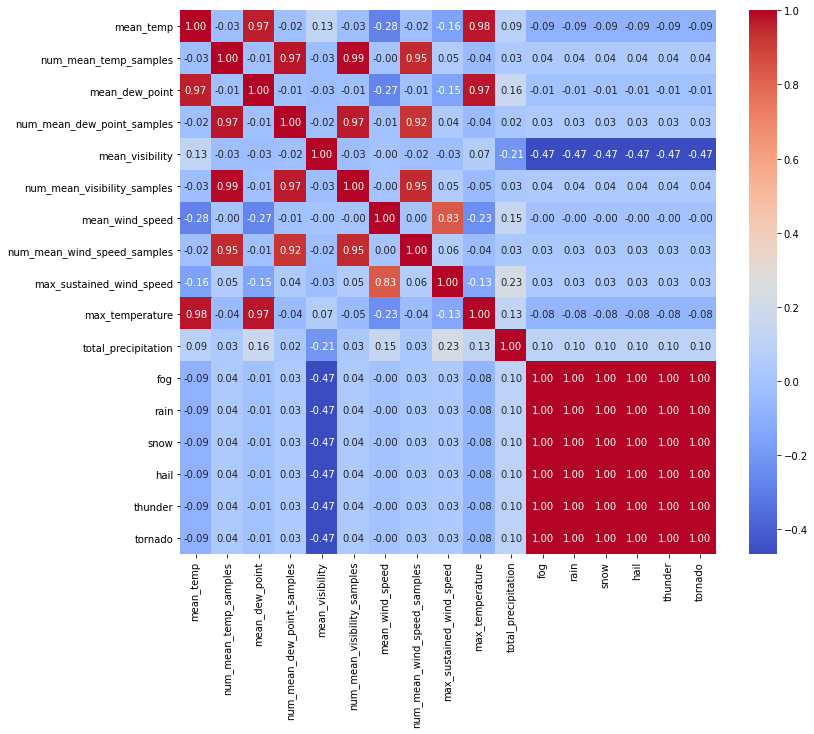

In [16]:
corr = df_small.iloc[:, 3:].corr(method='pearson')
fig, ax = plt.subplots(figsize=(12,10))  
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

We see that some of the columns are highly correlated with others. 

*   Interestingly, all the last 6 columns are perfectly correlated with each other. Since we want to predict the `snow`, it would be cheating to use the other 5, so we drop them. 

*   In addition, columns that indicate the number of sample to measure mean values also highly correlated with each other, therefore we keep only one of them.

*   Moreover, featues that have mean and max values per day also storngly correlates with each other. 

*   In addition, the correlation between `mean_temp` and `mean_dew_point` is 0.97, which means we can drop one of them as well.



In [17]:
cols_to_drop = ['mean_dew_point', 'num_mean_dew_point_samples', 'num_mean_visibility_samples', 
 'num_mean_wind_speed_samples', 'max_sustained_wind_speed', 'max_temperature', 'max_temperature_explicit',
 'fog', 'rain', 'hail', 'thunder', 'tornado']
df_small.drop(cols_to_drop, axis=1, inplace=True)
df_small.head()

,date,station_number,wban_number,mean_temp,num_mean_temp_samples,mean_visibility,mean_wind_speed,total_precipitation,snow
0,2005-01-01,725300,94846,32.099998,24,9.9,8.7,0.00,False
1,2005-01-02,725300,94846,42.799999,24,6.1,9.4,0.25,True
2,2005-01-03,725300,94846,34.599998,24,6.3,7.8,0.09,True
3,2005-01-04,725300,94846,32.299999,24,7.7,9.3,0.34,True
4,2005-01-05,725300,94846,29.700001,24,2.0,15.4,0.16,True


Let's visualize the remaining features

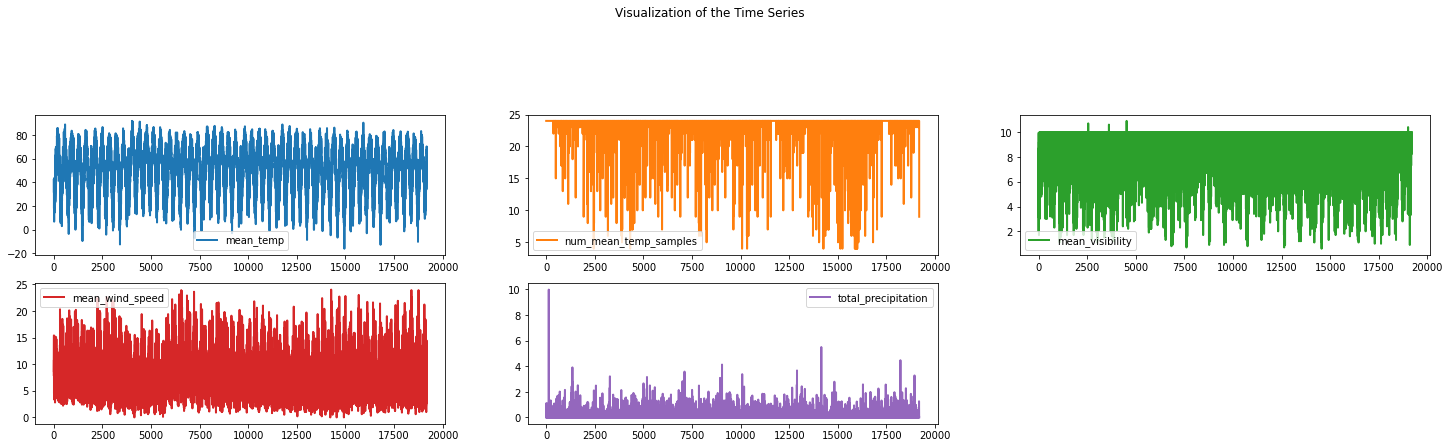

In [18]:
features = ['mean_temp','num_mean_temp_samples','mean_visibility','mean_wind_speed',
         'total_precipitation']
df_small[features].plot(subplots=True,
        layout=(5, 3),
        figsize=(25,15),
        linewidth=2,
        sharex=False,
        title='Visualization of the Time Series')
plt.show()

Do we really need all these features?

According to the heatmap above, only `mean_visibility` seems to have a relatively stronger correlation with the target value. The other ones don't have a significant correlation with it. However, Pearson correlation coefficient is originally used between two continous variables, thus it might be misleading. 

In the case of a relationship between a continous and a categorical variable, we can make use of box plots for visual interpretation, or we can use the ANOVA test for more scientific approach.



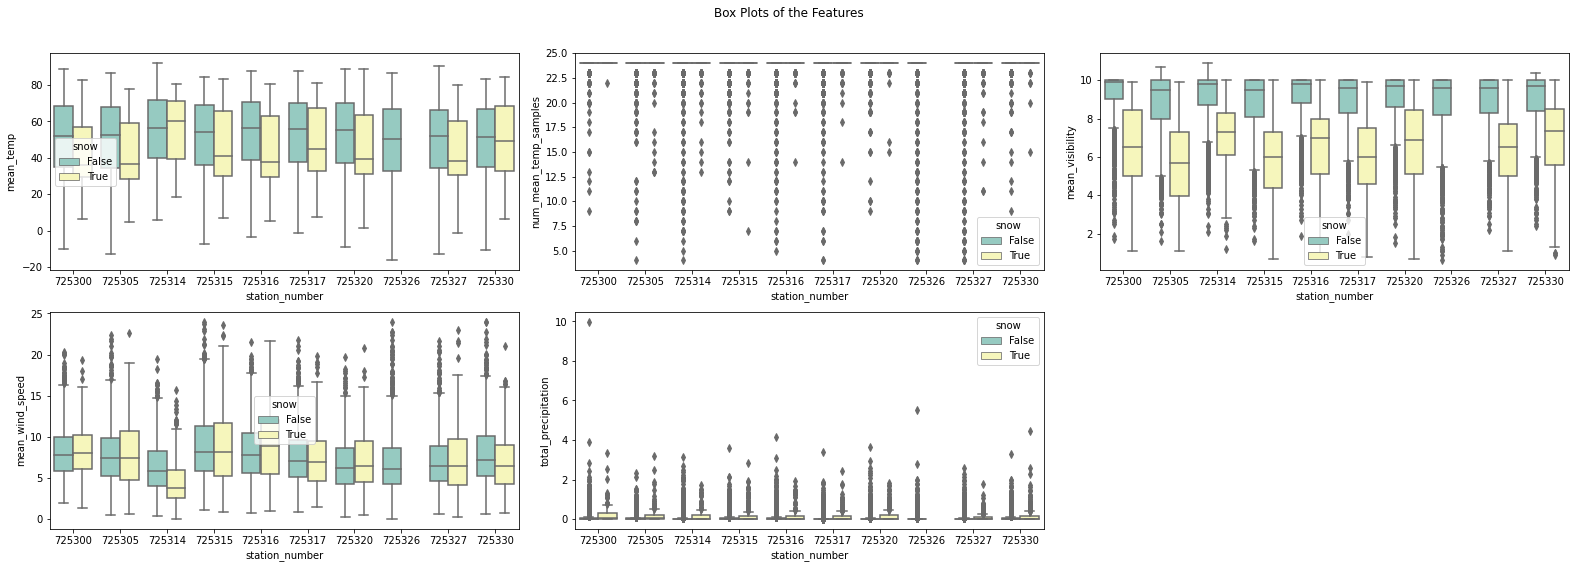

In [19]:
plt.figure(figsize=(22,8))
i = 1
for feature in features:
    plt.subplot(2, 3, i)
    sns.boxplot(x='station_number', y=feature, hue='snow', data=df_small, palette="Set3")
    i += 1
plt.tight_layout()
plt.suptitle('Box Plots of the Features')
plt.subplots_adjust(top=0.9)
plt.show()

The figure clearly show that a significant change occurs only in `mean_visibilty` boxe plots when it snows.

Also according to the ANOVA test, the best feature is again `mean_visibility`

In [20]:
k_best = SelectKBest(score_func=f_classif, k=1)
a = k_best.fit_transform(df_small[features], df_small['snow'])

pd.DataFrame(k_best.get_support(), index=features, columns=['Included'])

,Included
mean_temp,False
num_mean_temp_samples,False
mean_visibility,True
mean_wind_speed,False
total_precipitation,False


### 3. Task
**Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for is the following, and hence should constitute your test set.**

We start by defining our data as a `pandas.DataFrame` and save it as a csv file for later use

In [21]:
data = df_small[['date', 'station_number','mean_visibility', 'snow']]
data.head()

,date,station_number,mean_visibility,snow
0,2005-01-01,725300,9.9,False
1,2005-01-02,725300,6.1,True
2,2005-01-03,725300,6.3,True
3,2005-01-04,725300,7.7,True
4,2005-01-05,725300,2.0,True


In [22]:
data.to_csv('7L_Coding_Challenge_data_small.csv', index=False)

The target date is 11 years ago today as explained in the intorduction

In [23]:
target_date = datetime.date.today() - timedelta(days=11*365)
target_date_str = str(target_date).split(' ')[0]
print(f'Target Date: {target_date_str}')

Target Date: 2010-04-09


I decided to use 60 as my windows size to train later the LSTM model. I believe that 2 month windows will provide enough information to predict the next day.

My test set will only include one time window per station before the target day we want to forecast. Therefore, validation set will end 61 days before tha target date. 

In other words, if I want to forecast the visibilty for time $t$, I need the time window before it, which is the data from $t_{-60}$ to $t_{-1}$

In [24]:
window_size = 60

In [25]:
# Validation data will end window_size + 1 days before the target date
val_end_date = target_date - timedelta(days=window_size + 1)
val_end_date_str = str(val_end_date).split(' ')[0]

In [26]:
# Train data will start from the beginning and end exactly one year before the end of validation set
train_end_date = val_end_date - timedelta(days=365)
train_end_date_str = str(train_end_date).split(' ')[0]

In [27]:
train_data = data[data['date'] <= train_end_date]
train_data

,date,station_number,mean_visibility,snow
0,2005-01-01,725300,9.9,False
1,2005-01-02,725300,6.1,True
2,2005-01-03,725300,6.3,True
3,2005-01-04,725300,7.7,True
4,2005-01-05,725300,2.0,True
...,...,...,...,...
18751,2009-02-03,725330,8.1,False
18752,2009-02-04,725330,8.3,False
18753,2009-02-05,725330,9.7,False
18754,2009-02-06,725330,10.0,False


So our train set covers roughly 4 years of data from 2005-1-1 to 2009-2-6

In [28]:
val_data = data[(data['date'] > train_end_date) & (data['date'] <= val_end_date)]
val_data

,date,station_number,mean_visibility,snow
1495,2009-02-08,725300,7.9,False
1496,2009-02-09,725300,4.1,False
1497,2009-02-10,725300,9.1,False
1498,2009-02-11,725300,4.9,True
1499,2009-02-12,725300,10.0,False
...,...,...,...,...
19116,2010-02-03,725330,3.8,False
19117,2010-02-04,725330,8.2,False
19118,2010-02-05,725330,5.3,True
19119,2010-02-06,725330,5.8,False


Our validation set is the data of the whole year before the test set

In [29]:
test_data = data[(data['date'] > val_end_date) & (data['date'] <= target_date)]
test_data

,date,station_number,mean_visibility,snow
1860,2010-02-08,725300,10.0,False
1861,2010-02-09,725300,3.9,True
1862,2010-02-10,725300,6.0,True
1863,2010-02-11,725300,10.0,False
1864,2010-02-12,725300,10.0,False
...,...,...,...,...
19177,2010-04-05,725330,10.0,False
19178,2010-04-06,725330,10.0,False
19179,2010-04-07,725330,9.0,False
19180,2010-04-08,725330,8.2,False


As I explained above, test set covers 61 days of data (window size + the target date, which will be used as the labels for the time windows), accross 10 stations, thus we have 610 rows.

## Part 2
**If you made it up to here all by yourself, you can use your prepared dataset to train an Algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:**

**You are allowed to use any library you are comfortable with such as sklearn, tensorflow keras etc.**
**If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1.**

Before we start training the classifier, first we will normalize the data

In [ ]:
std_scaler = StandardScaler()

# The only numerical column is 'mean_visibility'
# So we normalize only that one, which is the 2nd last column of our data
train_data.iloc[:, -2] = std_scaler.fit_transform(train_data.iloc[:, -2].values.reshape(-1, 1))

# Validation and test sets will not be included to fit the scaler
val_data.iloc[:, -2] = std_scaler.transform(val_data.iloc[:, -2].values.reshape(-1, 1))
test_data.iloc[:, -2] = std_scaler.transform(test_data.iloc[:, -2].values.reshape(-1, 1))

### Classification

#### Data Preprocessing for the Classifier

Since we are asked to predict the snow for each station, we can include station numbers as one-hot encoded dummy variables to use them as features for the classifier

In [31]:
def get_station_dummies(data):
    '''
    Get dummy variables for each station in the data

    data: pd.DataFrame object to add dummies
    '''
    data = pd.concat((data, pd.get_dummies(data['station_number'])), axis=1)
    data.drop(columns=["station_number"], inplace=True)
    return data

In [32]:
train_data_clf = get_station_dummies(train_data)
train_data_clf

,date,mean_visibility,snow,725300,725305,725314,725315,725316,725317,725320,725326,725327,725330
0,2005-01-01,0.699144,False,1,0,0,0,0,0,0,0,0,0
1,2005-01-02,-1.479676,True,1,0,0,0,0,0,0,0,0,0
2,2005-01-03,-1.365001,True,1,0,0,0,0,0,0,0,0,0
3,2005-01-04,-0.562278,True,1,0,0,0,0,0,0,0,0,0
4,2005-01-05,-3.830508,True,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18751,2009-02-03,-0.332928,False,0,0,0,0,0,0,0,0,0,1
18752,2009-02-04,-0.218253,False,0,0,0,0,0,0,0,0,0,1
18753,2009-02-05,0.584469,False,0,0,0,0,0,0,0,0,0,1
18754,2009-02-06,0.756482,False,0,0,0,0,0,0,0,0,0,1


In [33]:
val_data_clf = get_station_dummies(val_data)
test_data_clf = get_station_dummies(test_data)

In [34]:
label_encoder = LabelEncoder() # to encode labels as 0s and 1s instead of True and False

clf_features = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # relevant column indexes except 'date' and 'snow'

x_train_clf = train_data_clf.iloc[:, clf_features]
y_train_clf = label_encoder.fit_transform(train_data['snow'])

x_val_clf = val_data_clf.iloc[:, clf_features]
y_val_clf = label_encoder.fit_transform(val_data['snow'])

x_test_clf = test_data_clf.iloc[:, clf_features]
y_test_clf = label_encoder.fit_transform(test_data['snow'])

Our inputs for training the classifier looks like this. Now we can start training.

In [35]:
x_train_clf.shape, y_train_clf.shape

((14890, 11), (14890,))

#### Training the Classifier

I will use a simple linear classifier with built-in cross validation. Other classification models, such as SVMs or Random Forests, can be used for this task as well, but I observed that the linear classifier is performing on the same level as them for this task, and it is way faster to do cross validate and train. 

In [36]:
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=False)
clf.fit(x_train_clf, y_train_clf)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  class_weight=None, cv=None, fit_intercept=True,
                  normalize=False, scoring=None, store_cv_values=False)

In [37]:
def clf_report(x, y):
    '''
    A helper function to report classification results after training. 
    
    x: array of data points to predict
    y: true labels
    '''
    # Classification Report
    preds = clf.predict(x)
    print(classification_report(y, preds))

    # Confusion Matrix
    cm = confusion_matrix(y, preds)
    palette = sns.color_palette("Blues", as_cmap=True)
    sns.heatmap(cm, annot=True, fmt='.0f', cmap=palette, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Observed')
    plt.show()

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     13012
           1       0.65      0.20      0.31      1878

    accuracy                           0.89     14890
   macro avg       0.77      0.59      0.62     14890
weighted avg       0.86      0.89      0.86     14890



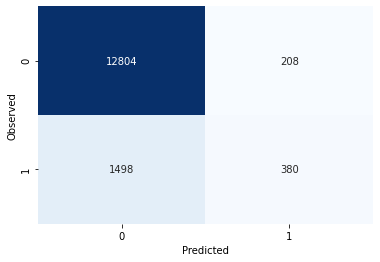

In [38]:
clf_report(x_train_clf, y_train_clf)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3287
           1       0.50      0.27      0.35       332

    accuracy                           0.91      3619
   macro avg       0.72      0.62      0.65      3619
weighted avg       0.89      0.91      0.90      3619



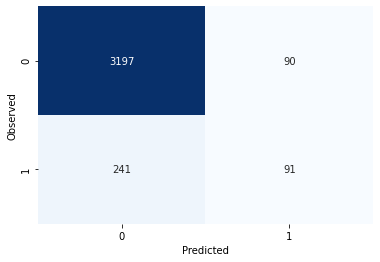

In [39]:
clf_report(x_val_clf, y_val_clf)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       546
           1       0.50      0.42      0.46        64

    accuracy                           0.90       610
   macro avg       0.72      0.69      0.70       610
weighted avg       0.89      0.90      0.89       610



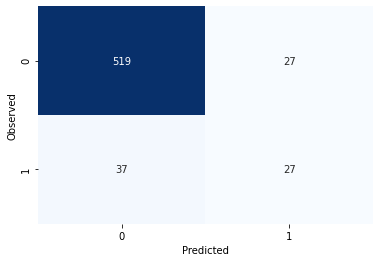

In [40]:
clf_report(x_test_clf, y_test_clf)

Classification results are not ideal, but not that bad either. The results look similar on all three sets, which indicates there is at least no sign of overfitting. 

First thing that srikes is the low recall for snowy days. This is probably mostly due to the lack of snowy days in data and the features we use are not that much correlated with snow. 

There is a trade-off here, I tried giving class weights to the classifier to balance the positive and negative samples. It increased the recall for snow, but it came with the cost of lower F1 scores overall. Thus, I decided to keep the biased classifier.

In [41]:
# Save the model as pickle file for later use
with open('RidgeClassifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

### Forecasting

#### Data Preprocessing for the RNN Model

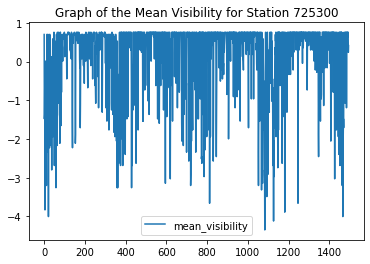

In [42]:
train_data.loc[train_data['station_number']==725300, ['mean_visibility']].plot()
plt.title('Graph of the Mean Visibility for Station 725300')
plt.show()

While working on time series forecasting, it is advised to use non-stationary data to mitigate the effects of seasonality and trends. So, before training, we will transform our data by claculating the difference between two consecutive observations to make it non-stationary

In [43]:
def make_non_stationary(data):
    '''
    Takes a pd.DataFrame and returns transformed version of it after 
    calculating the difference between two consecutive obserbations

    data: pd.DataFrame object to transform
    '''
    data_transformed = data.copy()
    
    # Transformation will be applied to the data of each station separately 
    # It will not make sense to calculate difference between the last value of 
    # a station and the first value of another station
    for station in stations_to_keep:
        data_transformed.loc[data['station_number']==station, ['mean_visibility']] = data_transformed.loc[data['station_number']==station, ['mean_visibility']].diff()
    
    # First rows for each station will be NaN values
    # We fill them by copying the value of the next row instead of directly dropping them
    data_transformed = data_transformed.fillna(method='bfill')
    return data_transformed

The default activation function for LSTM and GRU modules is the hyperbolic tangent (`tanh`) function, which outputs values between -1 and 1. Therfore we will scale the resulting transformed data again to make values within this range

In [44]:
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

In [45]:
train_data_rnn = make_non_stationary(train_data)
train_data_rnn.iloc[:, -2] = minmax_scaler.fit_transform(train_data_rnn.iloc[:, -2].values.reshape(-1, 1))

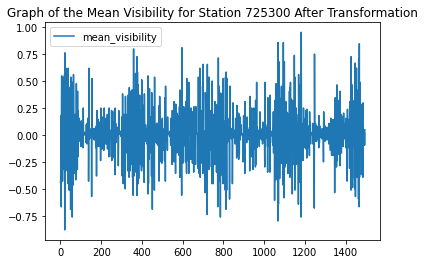

In [46]:
train_data_rnn.loc[train_data_rnn['station_number']==725300, ['mean_visibility']].plot()
plt.title('Graph of the Mean Visibility for Station 725300 After Transformation')
plt.show()

Here is how the same data above looks like after making it non-stationary

In [47]:
# Apply the same for validation and test sets
val_data_rnn = make_non_stationary(val_data)
val_data_rnn.iloc[:, -2] = minmax_scaler.transform(val_data_rnn.iloc[:, -2].values.reshape(-1, 1))

test_data_rnn = make_non_stationary(test_data)
test_data_rnn.iloc[:, -2] = minmax_scaler.transform(test_data_rnn.iloc[:, -2].values.reshape(-1, 1))

In [48]:
num_features = 1 # The only feature we will forecast is 'mean_visibility'

def extract_windows(df, window_size):
    '''
    Extract windows and their respective labels from the given data.

    df: pd.DataFrame object to extract windows from
    window_size: integer value to determine window size
    '''

    x = []
    labels = []

    # Windows will be extracted seperately for each station
    for station in stations_to_keep:
        temp_ = df[df['station_number'] == station]  # a temporal dataframe 
        for i in range(0, len(temp_) - window_size):
            # get the values for the time window starting from the current index
            x_ = temp_.iloc[i : i + window_size]    
            x.append(x_['mean_visibility'].values)

            # get the value at the next index as the label for this time window
            labels.append(temp_.iloc[i + window_size, -2])


    x_train = np.zeros((len(x), window_size, num_features))
    x = np.asarray(x, dtype=float)

    for i in range(len(x)):
        x_train[i] = x[i].reshape(-1, 1)  # match the shapes

    y_train = np.asarray(labels)

    return x_train, y_train

In [49]:
x_train_rnn, y_train_rnn = extract_windows(train_data_rnn, window_size)
x_train_rnn.shape, y_train_rnn.shape

((14290, 60, 1), (14290,))

In [50]:
x_val_rnn, y_val_rnn = extract_windows(val_data_rnn, window_size)
x_val_rnn.shape, y_val_rnn.shape

((3019, 60, 1), (3019,))

In [51]:
x_test_rnn, y_test_rnn = extract_windows(test_data_rnn, window_size)
x_test_rnn.shape, y_test_rnn.shape

((10, 60, 1), (10,))

Our test set is composed of 10 samples, 1 sample for each station with 60 days prior values. The labels for the test set is the observed `mean_visibility` values for the target date

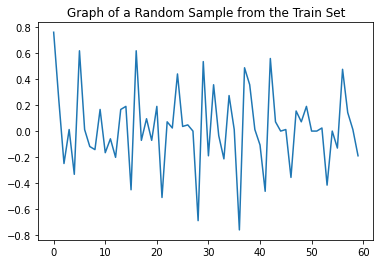

In [52]:
# Graph a random sample from the train set
plt.plot(x_train_rnn[22])
plt.title('Graph of a Random Sample from the Train Set')
plt.show()

#### RNN Model Training

We have a rather simple RNN model with 3 stacked LSTM layers and a linear (Dense) at the end, which will try to predict the next value given a time series of window size

In [53]:
def LSTM_Model(input_shape, n_units):
    '''
    Creates and compiles the RNN Model. Returns a Keras model object and the model callbacks.

    input_shape: tuple indicating the input shape for the RNN. (batch_size, n_timesteps, n_features)
    n_units: integer value that defines the number of LSTM units in LSTM layers
    '''

    # Create the model
    input_rnn = Input(input_shape)
    z = LSTM(n_units, return_sequences=True)(input_rnn)
    z = LSTM(n_units, return_sequences=True)(z)
    z = LSTM(n_units)(z)

    output_rnn = Dense(1)(z)
    
    model = Model(inputs=input_rnn, outputs=output_rnn)

    # Compile the model
    model.compile(loss='mse', optimizer=keras.optimizers.Adam())
    print(model.summary())

    # Define model callbacks for the training process
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
                                                      min_lr=0.0001) 

    file_path = f'LSTM_Model.hdf5'

    model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='val_loss',
                                                        save_best_only=True)

    callbacks = [reduce_lr, model_checkpoint]

    return model, callbacks

Here is how the model architecture looks like

In [54]:
in_shape = x_train_rnn[0].shape
nn_model, callbacks = LSTM_Model(in_shape, 32)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________
None


Now we can fit this model to our data

In [55]:
history = nn_model.fit(
    x_train_rnn,
    y_train_rnn,
    epochs=100,
    batch_size = 512,
    validation_data=(x_val_rnn, y_val_rnn),
    callbacks=callbacks,
)

Epoch 1/100
28/28 [==============================] - 35s 58ms/step - loss: 0.0463 - val_loss: 0.0455
Epoch 2/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0452 - val_loss: 0.0425
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0415 - val_loss: 0.0384
Epoch 4/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0349 - val_loss: 0.0372
Epoch 5/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0331 - val_loss: 0.0361
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0327 - val_loss: 0.0363
Epoch 7/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0327 - val_loss: 0.0360
Epoch 8/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0324 - val_loss: 0.0360
Epoch 9/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0325 - val_loss: 0.0361
Epoch 10/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0321 - val_loss: 0.036

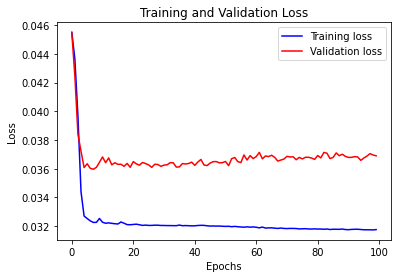

In [56]:
def visualize_loss(history, title):
    '''
    Helper function to plot the train and validation losses

    history: history of the training returned by the fit() function of Keras
    title: Title string
    '''
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

It appears that our model fits after roughly 10 epochs and there is no sign of overfitting in the graph

Let's see how the predictions look like in general. 

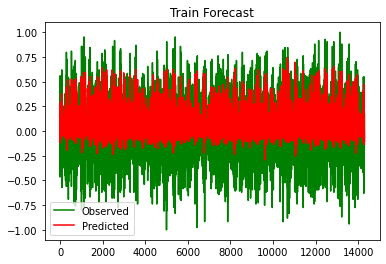

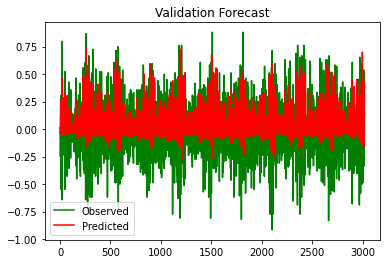

In [57]:
def plot_forecast(x, y, title):
    '''
    Helper function to plot observed values and forecasts
    
    x: 3D np.array to predict
    y: true labels
    title: title string
    '''
    preds = nn_model.predict(x)
    plt.plot(y, c='g', label='Observed')
    plt.plot(preds, c='r', label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()


plot_forecast(x_train_rnn, y_train_rnn, 'Train Forecast')
plot_forecast(x_val_rnn, y_val_rnn, 'Validation Forecast')

The model does an alright job predicting the values above 0, but there seems to be an underfitting for negative values. The magnitudes are way lower than actual values.

Now that we have trained our RNN and the classifier, we can predict for the target day. 

To do that, we have to convert back the values predicted by the RNN to their original values, which means that we have to inverse transform them. 

### Predict the Target Day

In order for our predictions to make sense, we have to revert them to their original values. Because, right now our RNN model outputs the predicted change from previous sample. However, our classifier needs the exact value of `mean_visibility`.

We can do this in four steps:

1.   Append the predictions to the end of the given time series windows
2.   Inverse the MinMax Scaling
3.   Replace the first values of given samples with their original values
4.   Inverse the difference transformation by calculating cumulative sums for each sample



In [58]:
def revert_to_original(x, preds, start_values):
    '''
    Reverts the given values by first inverse transforming according to the MinMax Sclaer,
    then calculates cumulative sum to convert back to the original states
    
    x: 3D np.array 
    preds: array of predictions
    start_values: first values are needed to calculate cumulative sums,
                  as the values of next observations will be added to that value
    '''
    
    # Empty array of shape (batch_size, window_size+1, n_features)
    # +1 in the second dimension is tha appended prediction to the given window
    x_appended = np.empty((x.shape[0], x.shape[1]+1, x.shape[2]))
    
    for i in range(len(x)):
        # Concatenate x and the respective prediction for that x
        x_appended[i] = np.concatenate((x[i], preds[i].reshape(-1,1)), axis=0)
        # Invese transform 
        x_appended[i]  = minmax_scaler.inverse_transform(x_appended[i] )
    

    # Replace start values
    for i in range(len(x_appended)):
        x_appended[i, 0] = start_values[i]
        # Move on by adding the values to the original starting value
        x_appended[i] = np.cumsum(x_appended[i]).reshape(-1, 1)
    
    return x_appended

In [ ]:
# Predict values for the target date
preds_test = nn_model.predict(x_test_rnn)

In [62]:
# Get the original starting values for test set by looking at the rows 
# where date is one day after the validation set ends, i.e. first day of test set
test_start_values = test_data_clf.loc[test_data_clf['date'] == val_end_date + timedelta(1), 'mean_visibility'].values

In [63]:
# Revert them to original
preds_test_reverted = revert_to_original(x_test_rnn, preds_test, test_start_values)
preds_test_reverted.shape

(10, 61, 1)

As we wanted, now we have values for 61 days including the forecasted values at the end

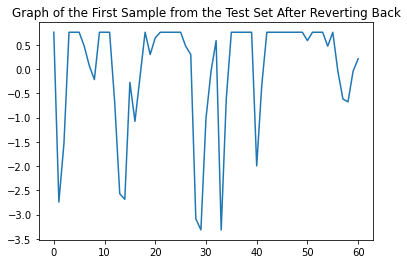

In [64]:
plt.plot(preds_test_reverted[0])
plt.title('Graph of the First Sample from the Test Set After Reverting Back')
plt.show()

Now we can prepare our input for the linear classifier

In [65]:
# Get the relevant rows for the station information that will be used for making the prediction
test_data_on_target_day = test_data_clf.loc[test_data_clf['date'] == target_date, stations_to_keep]

# Insert the predicted value to the DataFrame
test_data_on_target_day.insert(0, "mean_visibility_predicted", preds_test_reverted[:, -1], True)
test_data_on_target_day

,mean_visibility_predicted,725300,725305,725314,725315,725316,725317,725320,725326,725327,725330
1920,0.209440,1,0,0,0,0,0,0,0,0,0
3850,0.192901,0,1,0,0,0,0,0,0,0,0
5756,0.395320,0,0,1,0,0,0,0,0,0,0
7686,0.114416,0,0,0,1,0,0,0,0,0,0
9616,0.464567,0,0,0,0,1,0,0,0,0,0
11544,0.498547,0,0,0,0,0,1,0,0,0,0
13474,0.389608,0,0,0,0,0,0,1,0,0,0
15365,0.277818,0,0,0,0,0,0,0,1,0,0
17252,-0.263442,0,0,0,0,0,0,0,0,1,0
19181,-0.015103,0,0,0,0,0,0,0,0,0,1


In [66]:
# Get the predictions for the target day
snow_preds = clf.predict(test_data_on_target_day)

Let's show the actual values for the target day and the predictions from our model together

In [67]:
target_df = test_data[test_data['date']==target_date]
target_df.insert(4, "snow_forecasted", snow_preds, True)
target_df

,date,station_number,mean_visibility,snow,snow_forecasted
1920,2010-04-09,725300,0.756482,False,0
3850,2010-04-09,725305,0.756482,False,0
5756,2010-04-09,725314,0.756482,False,0
7686,2010-04-09,725315,0.527132,False,0
9616,2010-04-09,725316,0.756482,False,0
11544,2010-04-09,725317,0.756482,False,0
13474,2010-04-09,725320,0.756482,False,0
15365,2010-04-09,725326,0.756482,False,0
17252,2010-04-09,725327,0.469795,False,0
19181,2010-04-09,725330,0.756482,False,0


Our model successfully predicts correct for all stations in this case.

## Possible Improvements and Final Remarks

If I were to invest more time on this project, I would definitely make use of the complete data, not a small subset. This might help the models generalize the data better. In this case, it might not be very useful to use a separate classifier since our data would be vastly sparse (more than 9000 dummy variables for one feature). 

One alternative approach in this situation might be to build a RNN with two heads. The first head will be similar to this one, which will extract time dependent features. The other head will be an auto-encoder, that takes the one-hot encoded station information as input, and will reduce the dimensionality of it. Then the output of both heads will be concatenated to predict the snow at the end.

One other thing is that, during the feauture selection, I only considered the relationship between each feature and the target value. However, one might wonder that what if there are some hidden relationships in the data where a set of independent variables can have more prediction power than a single feature. To answer this question, I implemented a Random Forest before the linear classifier, using all the features, and achieved similar results on validation and test sets. Although it achieved almost perfect scores on the train set, that was apparently the result of overfitting.

Obviously the performance of the classifier and the RNN in this solution could be further improved as well, as they are not the perfect models, by putting more effort on issues like more detailed feature engineering, model architecture search, cross validation and hyper-parameter optimization. 